In [1]:
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import folium
from folium import plugins
import json

warnings.filterwarnings('ignore')
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.figsize"] = (16,8)
plt.rc('font',family='Batang')

geo_path = 'C:/Users/keogu/Desktop/I-GPS/data/seoul_municipalities_geo_simple.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))

# 서울특별시 공공자전거 대여소
- http://data.seoul.go.kr/dataList/OA-13252/F/1/datasetView.do

## 대여소 분포

In [2]:
# 대여소 정보 데이터 불러오기
stop = pd.read_csv('C:/Users/keogu/Desktop/I-GPS/data/공공자전거 대여소 정보_2021.01.31.csv')
stop.head()

,대여소번호,보관소(대여소)명,자치구,상세주소,위도,경도,설치시기,LCD,QR,운영방식
0,301,경복궁역 7번출구 앞,종로구,서울특별시 종로구 사직로 지하130,37.575794,126.971451,2015-10-07,16.0,NaN,LCD
1,302,경복궁역 4번출구 뒤,종로구,서울특별시 종로구 사직로 지하130,37.575947,126.974060,2015-10-07,12.0,NaN,LCD
2,303,광화문역 1번출구 앞,종로구,서울특별시 종로구 세종대로 지하189,37.571770,126.974663,2015-10-07,8.0,NaN,LCD
3,304,광화문역 2번출구 앞,종로구,서울특별시 종로구 세종대로 지하172,37.572113,126.977577,2021-01-26,NaN,7.0,QR
4,305,종로구청 옆,종로구,서울특별시 종로구 삼봉로 43,37.572582,126.978355,2015-10-07,16.0,NaN,LCD


In [3]:
# 데이터 전처리
stop = stop.fillna(0)
stop['거치대수'] = stop['LCD'] + stop["QR"]
stop.drop(['LCD','QR','운영방식'],axis=1,inplace=True)
stop.head()

,대여소번호,보관소(대여소)명,자치구,상세주소,위도,경도,설치시기,거치대수
0,301,경복궁역 7번출구 앞,종로구,서울특별시 종로구 사직로 지하130,37.575794,126.971451,2015-10-07,16.0
1,302,경복궁역 4번출구 뒤,종로구,서울특별시 종로구 사직로 지하130,37.575947,126.974060,2015-10-07,12.0
2,303,광화문역 1번출구 앞,종로구,서울특별시 종로구 세종대로 지하189,37.571770,126.974663,2015-10-07,8.0
3,304,광화문역 2번출구 앞,종로구,서울특별시 종로구 세종대로 지하172,37.572113,126.977577,2021-01-26,7.0
4,305,종로구청 옆,종로구,서울특별시 종로구 삼봉로 43,37.572582,126.978355,2015-10-07,16.0


### 점분포

In [4]:
# 점분포
stop_map = folium.Map(location=[stop['위도'].mean(), stop['경도'].mean()], zoom_start=10.8, tiles='CartoDB positron')
for i, row in stop.iterrows():
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=1,
        fill=True,
    ).add_to(stop_map)

stop_map

### 히트맵 분포

In [5]:
# 히트맵 분포 
stop_map2 = folium.Map(location=[stop['위도'].mean(), stop['경도'].mean()], zoom_start=10.8, tiles='CartoDB positron')
plugins.HeatMap(stop[['위도', '경도']].values.tolist(),
                        radius=10, blur=5
                        ).add_to(stop_map2)
plugins.Fullscreen(positions='topright').add_to(stop_map2)

stop_map2

### 지역구별 대여소 개수

In [6]:
# 지역구별 대여소 개수
city_stop = stop.groupby('자치구').size()
city_stop = city_stop.sort_values(ascending=True, inplace=False)

In [7]:
city_stop

자치구
금천구      55
도봉구      57
강북구      59
동작구      62
관악구      66
용산구      67
중랑구      70
성북구      73
광진구      74
서대문구     74
중구       76
은평구      80
성동구      81
양천구      81
동대문구     82
강동구      84
노원구      88
구로구      91
종로구      99
마포구     102
영등포구    108
강남구     118
서초구     122
송파구     133
강서구     152
dtype: int64

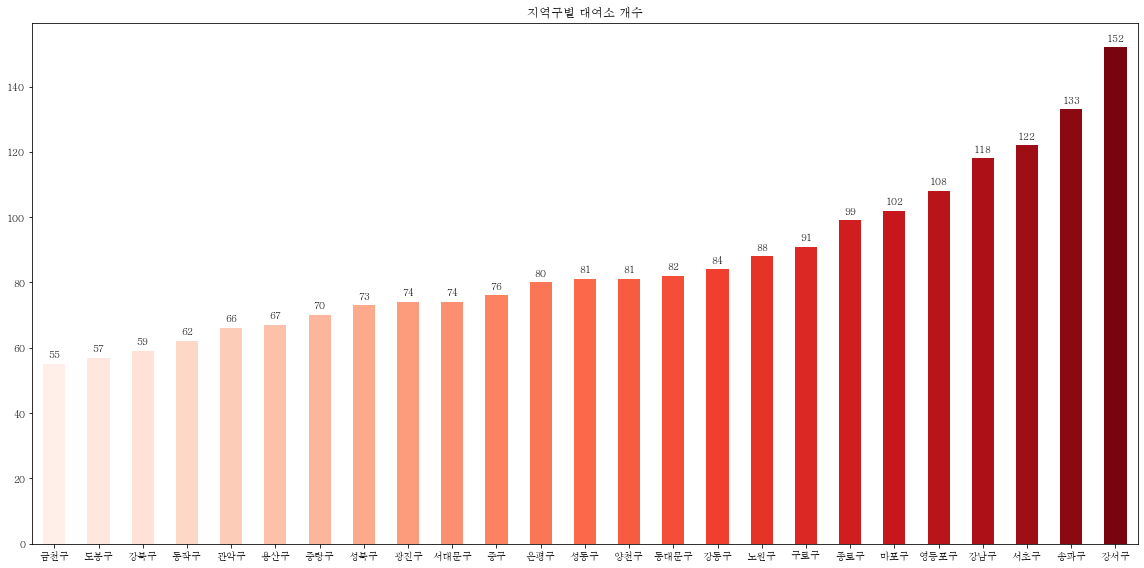

In [8]:
# 시각화
#강서구, 송파구, 서초구 순으로 가장 많은 대여소가 설치되어 있고 금천구가 56개의 대여소로 가장 적은 대여소가 설치되어 있다
colors = sns.color_palette("Reds",len(city_stop))
ax = city_stop.plot(kind='bar',color=colors,rot=0, title="지역구별 대여소 개수")
for p in ax.patches: 
    left, bottom, width, height = p.get_bbox().bounds 
    ax.annotate("%d"%(height), (left+width/2, height+2), ha='center')
plt.box(True)
plt.xlabel('')
plt.tight_layout()
plt.show()

In [9]:
# 시각화
city_stop_map = folium.Map(location=[stop['위도'].mean(), stop['경도'].mean()], zoom_start=11, tiles='cartodbpositron')
folium.Choropleth(geo_data=geo_str,
                  data=city_stop,
                  key_on='feature.properties.SIG_KOR_NM', 
                  fill_color='Reds').add_to(city_stop_map)
city_stop_map

# 서울특별시 공공자전거 대여이력 정보  
- http://data.seoul.go.kr/dataList/OA-15182/F/1/datasetView.do

In [10]:
# 대여이력 정보 데이터 불러오기
rental01 = pd.read_csv('C:/Users/keogu/Desktop/I-GPS/data/공공자전거 대여이력 정보/공공자전거 대여이력 정보_2020.01.csv',encoding='cp949')
rental02 = pd.read_csv('C:/Users/keogu/Desktop/I-GPS/data/공공자전거 대여이력 정보/공공자전거 대여이력 정보_2020.02.csv',encoding='cp949')
rental03 = pd.read_csv('C:/Users/keogu/Desktop/I-GPS/data/공공자전거 대여이력 정보/공공자전거 대여이력 정보_2020.03.csv',encoding='cp949')
rental04 = pd.read_csv('C:/Users/keogu/Desktop/I-GPS/data/공공자전거 대여이력 정보/공공자전거 대여이력 정보_2020.04.csv',encoding='cp949')
rental05 = pd.read_csv('C:/Users/keogu/Desktop/I-GPS/data/공공자전거 대여이력 정보/공공자전거 대여이력 정보_2020.05.csv',encoding='cp949')
rental06 = pd.read_csv('C:/Users/keogu/Desktop/I-GPS/data/공공자전거 대여이력 정보/공공자전거 대여이력 정보_2020.06.csv',encoding='cp949')
rental078 = pd.read_csv('C:/Users/keogu/Desktop/I-GPS/data/공공자전거 대여이력 정보/공공자전거 대여이력 정보_2020.07_08.csv',encoding='cp949')
rental09 = pd.read_csv('C:/Users/keogu/Desktop/I-GPS/data/공공자전거 대여이력 정보/공공자전거 대여이력 정보_2020.09.csv',encoding='cp949')
rental010 = pd.read_csv('C:/Users/keogu/Desktop/I-GPS/data/공공자전거 대여이력 정보/공공자전거 대여이력 정보_2020.10.csv',encoding='cp949')
rental011 = pd.read_csv('C:/Users/keogu/Desktop/I-GPS/data/공공자전거 대여이력 정보/공공자전거 대여이력 정보_2020.11.csv',encoding='cp949')
rental012 = pd.read_csv('C:/Users/keogu/Desktop/I-GPS/data/공공자전거 대여이력 정보/공공자전거 대여이력 정보_2020.12.csv',encoding='cp949')
rental11 = pd.read_csv('C:/Users/keogu/Desktop/I-GPS/data/공공자전거 대여이력 정보/공공자전거 대여이력 정보_2021.01.csv',encoding='cp949')

In [11]:
# 데이터 병합
allData = [rental01,rental02,rental03,rental04,rental05,rental06,rental078,rental09,rental010,rental011,rental012]
rental = pd.concat(allData, axis=0, ignore_index=True)

In [12]:
rental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18570545 entries, 0 to 18570544
Data columns (total 11 columns):
 #   Column    Dtype  
---  ------    -----  
 0   자전거번호     object 
 1   대여일시      object 
 2   대여 대여소번호  int64  
 3   대여 대여소명   object 
 4   대여거치대     object 
 5   반납일시      object 
 6   반납대여소번호   object 
 7   반납대여소명    object 
 8   반납거치대     int64  
 9   이용시간      float64
 10  이용거리      float64
dtypes: float64(2), int64(2), object(7)
memory usage: 1.5+ GB


In [13]:
rental.head()

,자전거번호,대여일시,대여 대여소번호,대여 대여소명,대여거치대,반납일시,반납대여소번호,반납대여소명,반납거치대,이용시간,이용거리
0,SPB-04061,2020-01-01 00:01:04,429,송도병원,2,2020-01-01 00:04:21,00372,약수역 3번출구 뒤,8,2.0,0.0
1,SPB-06686,2020-01-01 00:02:53,1637,KT 노원점 건물 앞,14,2020-01-01 00:04:48,01656,중앙하이츠 아파트 입구,9,1.0,350.0
2,SPB-15937,2020-01-01 00:01:21,1924,삼부르네상스파크빌,10,2020-01-01 00:05:51,01955,디지털입구 교차로,7,4.0,800.0
3,SPB-14805,2020-01-01 00:03:12,437,대흥역 1번출구,1,2020-01-01 00:05:54,00126,서강대 후문 옆,18,2.0,0.0
4,SPB-09038,2020-01-01 00:01:11,1168,마곡엠밸리10단지 앞,5,2020-01-01 00:05:57,01152,마곡역교차로,2,4.0,660.0


In [14]:
# 칼럼명 수정
rental.rename(columns={"대여 대여소번호":"대여소번호"},inplace=True)

In [15]:
# 대여이력 정보와 대여소 정보 병합
rental = pd.merge(rental, stop[['자치구', '대여소번호']], on='대여소번호')
rental.rename(columns={
    "대여소번호": "대여 대여소 번호",
    "자치구": "대여 지역"
}, inplace=True)
rental.head()

,자전거번호,대여일시,대여 대여소 번호,대여 대여소명,대여거치대,반납일시,반납대여소번호,반납대여소명,반납거치대,이용시간,이용거리,대여 지역
0,SPB-04061,2020-01-01 00:01:04,429,송도병원,2,2020-01-01 00:04:21,00372,약수역 3번출구 뒤,8,2.0,0.0,중구
1,SPB-25060,2020-01-01 04:01:28,429,송도병원,1,2020-01-01 04:15:14,00568,청계8가사거리 부근,5,13.0,2740.0,중구
2,SPB-23668,2020-01-01 16:50:06,429,송도병원,5,2020-01-01 17:54:28,02302,교보타워 버스정류장(신논현역 3번출구 후면),4,62.0,32500.0,중구
3,SPB-05788,2020-01-01 16:50:14,429,송도병원,7,2020-01-01 17:54:47,02302,교보타워 버스정류장(신논현역 3번출구 후면),5,64.0,6840.0,중구
4,SPB-11918,2020-01-01 17:59:15,429,송도병원,6,2020-01-01 18:08:58,00429,송도병원,6,9.0,0.0,중구


In [16]:
# 대여이력 정보와 대여소 정보 병합
rental = pd.merge(rental, stop[['자치구', '대여소번호']], left_on='반납대여소번호', right_on='대여소번호').drop(columns='대여소번호')
rental.rename(columns={
    "자치구": "반납 지역"
}, inplace=True)

rental.head()

,자전거번호,대여일시,대여 대여소 번호,대여 대여소명,대여거치대,반납일시,반납대여소번호,반납대여소명,반납거치대,이용시간,이용거리,대여 지역,반납 지역
0,SPB-03413,2020-01-06 16:15:37,429,송도병원,1,2020-01-06 16:46:59,612,시립동부병원 앞 사거리,3,31.0,4720.0,중구,동대문구
1,SPB-03791,2020-01-08 17:13:58,429,송도병원,5,2020-01-08 17:40:15,612,시립동부병원 앞 사거리,1,25.0,4620.0,중구,동대문구
2,SPB-06812,2020-01-09 17:30:15,429,송도병원,5,2020-01-09 18:01:02,612,시립동부병원 앞 사거리,3,30.0,5000.0,중구,동대문구
3,SPB-15155,2020-01-22 16:16:15,429,송도병원,3,2020-01-22 16:47:04,612,시립동부병원 앞 사거리,2,30.0,0.0,중구,동대문구
4,SPB-11995,2020-01-23 17:11:39,429,송도병원,4,2020-01-23 17:38:51,612,시립동부병원 앞 사거리,2,26.0,4040.0,중구,동대문구


## 지역구별 대여량

In [17]:
# 지역구별 대여량
rental_bike = rental.groupby('대여 지역').size()
rental_bike = rental_bike.sort_values(ascending=True, inplace=False)

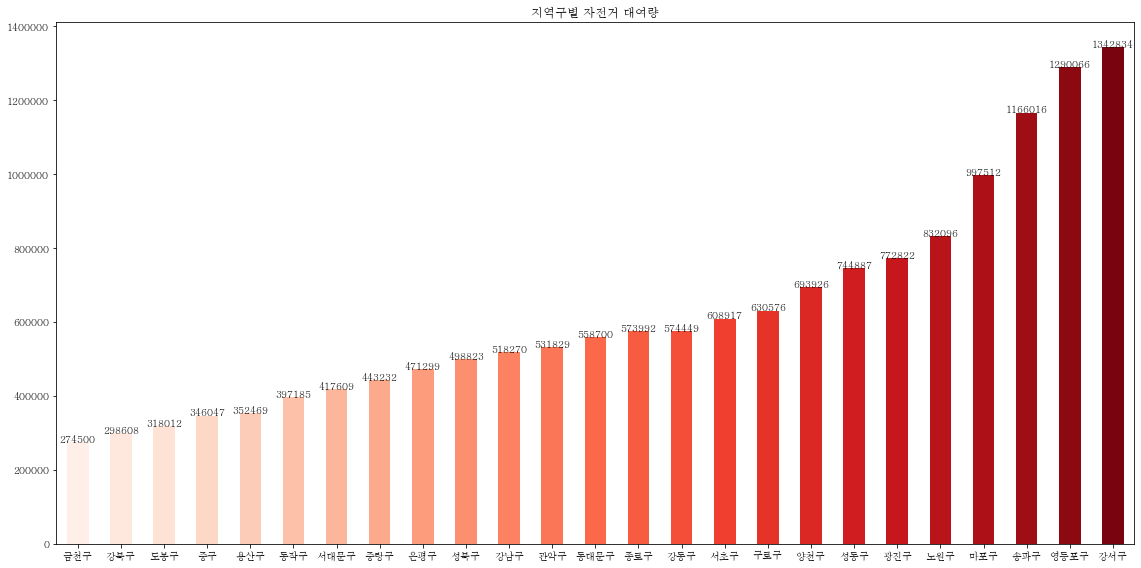

In [18]:
# 시각화
# 강서구,영등포구,송파구 순으로 높은 대여량을 기록하고 있으며 금천구가 가장 적은 대여량을 나타내고 있다
colors = sns.color_palette("Reds",len(rental_bike))
ax = rental_bike.plot(kind='bar', color=colors, rot=0, title="지역구별 자전거 대여량")
for p in ax.patches: 
    left, bottom, width, height = p.get_bbox().bounds 
    ax.annotate("%d"%(height), (left+width/2, height+2), ha='center')
plt.box(True)
plt.xlabel('')
plt.tight_layout()
plt.savefig('지역구별 자전거 대여량')
plt.show()

## 지역구별 반납량

In [19]:
# 지역구별 반납량
return_bike = rental.groupby('반납 지역').size()
return_bike = return_bike.sort_values(ascending=True, inplace=False)

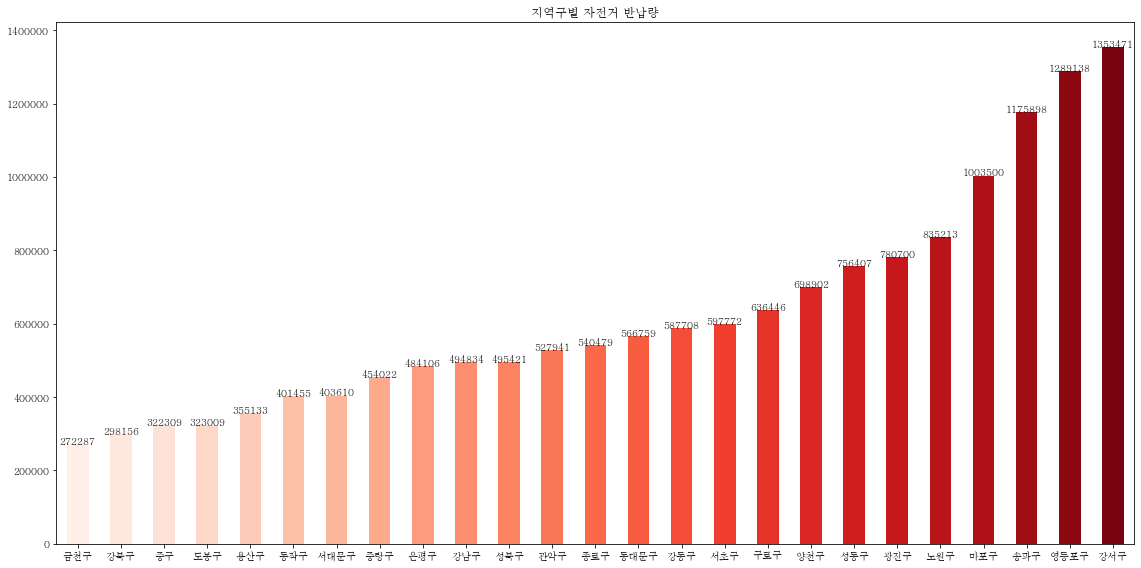

In [20]:
# 시각화
# 강서구,영등포구,송파구 순으로 높은 반납량을 기록하고 있으며 금천구가 가장 적은 반납량을 나타내고 있다
colors = sns.color_palette("Reds",len(return_bike))
ax = return_bike.plot(kind='bar',color=colors, rot=0, title="지역구별 자전거 반납량")
for p in ax.patches: 
    left, bottom, width, height = p.get_bbox().bounds 
    ax.annotate("%d"%(height), (left+width/2, height+2), ha='center')
plt.box(True)
plt.xlabel('')
plt.tight_layout()
plt.savefig('지역구별 자전거 반납량')
plt.show()

# 대여소 수/인구 수

## 지역구별 1명 당 평균 대여소 

In [29]:
df = pd.read_excel('C:/Users/keogu/Desktop/I-GPS/data/서울시 지역구별 인구.xls')

In [31]:
df.drop(index=[0,1,2],inplace=True)

In [32]:
# 지역구별 인구 수
people = df[['자치구','인구']]

In [34]:
# 지역구별 대여소
stop = city_stop.to_frame(name='대여소')
stop = stop.reset_index()

In [37]:
rate = pd.merge(people,stop,on='자치구')

In [38]:
rate['대여소/인구'] = rate['대여소']/rate['인구']

In [40]:
rate

,자치구,인구,대여소,대여소/인구
0,종로구,155106,99,0.000638
1,중구,132259,76,0.000575
2,용산구,240665,67,0.000278
3,성동구,295767,81,0.000274
4,광진구,355306,74,0.000208
5,동대문구,352259,82,0.000233
6,중랑구,394679,70,0.000177
7,성북구,443206,73,0.000165
8,강북구,306093,59,0.000193
9,도봉구,322419,57,0.000177


In [41]:
# 지역구별 인구 1명당 평균 대여소 개수
rate['대여소/인구'].mean()

0.0002431018545413867

# 결과
**서울시 구별로 인구와 대여소 수를 구해본 결과 다음과 같다**  
**인천시 미추홀구의 도입되는 적정한 대여소 수를 찾기 위해 서울시 대여소 수/인구 수의 비율을 구함**  
**구한 평균 비율인 0.000243을 인천시 미추홀구 인구 수와 곱해서 적정한 대여소 수를 찾는다**